Сие уравнение, предложенное Дж. Хиггинсом, описывает простейшую модель гликолиза
\begin{cases}
\dot{x} = 1 - xy & \\
\dot{y} = \alpha y \Big( x - \frac{1 + \beta}{ y + \beta} \Big)
\end{cases}

In [1]:
import numpy as np
y1_init = 1.
y2_init = 0.001
beta = 10. #10
alpha = 1000. # 100, 200, 400, 1000


In [2]:
def glicole(t, u, jac=False):    
    x, y = u
    if jac:
        return np.array([[-y, -x], [alpha * y, alpha * x - alpha * (1 + beta) * beta / ((y + beta)**2)]])
    return np.array([1. - x * y,
                    alpha * y * (x - (1. + beta) / (y + beta))])
glicole_init = np.array([1., 0.001])
glicole_tmax = 15

Попробуем решить задачу методами Рунге-Кутты 1го, 2го и 4го порядков со следующими таблицами Бутчера: 
$$RK4$$
\begin{array}
{c|cccc}
0\\
\frac{1}{2} & \frac{1}{2}\\
\frac{1}{2} &0 &\frac{1}{2} \\
1& 0& 0& 1\\
\hline
& \frac{1}{6} &\frac{1}{3} &\frac{1}{3} &\frac{1}{6} 
\end{array}



$$MidPoint$$
\begin{array}
{c|cc}
0\\
\frac{1}{2} & \frac{1}{2}\\
\hline
& 0 & 1
\end{array}


$$Euler$$
\begin{array}
{c|c}
0\\
\hline
& 1 
\end{array}

In [3]:
def euler(f, tau, t, u):
    k1 = f(t, u)
    return u + tau * k1
euler.order = 1; euler.name = 'Явный метод Эйлера'

def midpoint(f, tau, t, u):
    k1 = f(t, u)
    k2 = f(t + tau/2, u + tau/2*k1)
    return u + tau * k2
midpoint.order = 2; midpoint.name = 'Явный метод средней точки'

def rk4(f, tau, t, u):
    k1 = f(t, u)
    k2 = f(t + tau/2, u + tau/2*k1)
    k3 = f(t + tau/2, u + tau/2*k2)
    k4 = f(t + tau  , u + tau  *k3)
    return u + tau * (k1 + 2*k2 + 2*k3 + k4) / 6
rk4.order = 4; rk4.name = 'Классический метод РК 4 порядка'

In [4]:
def fixed_stepsize(f, y0, tmax, method, tau=0.1):
    t = 0; u = y0
    T = [0]; Y = [y0]; Y_ = [f(t, y0)]
    name = method.name
    while t < tmax:
        # Если последний шаг выхдит за tmax - уменьшаем tau
        if t + tau > tmax: tau = tmax - t
        u = method(f, tau, t, u)
        t += tau;
        T.append(t)
        Y.append(u)
        Y_.append(f(t, u))
    print('%s, всего шагов: %d'%(name, len(T)-1))
    return np.array(T), np.array(Y), np.array(Y_)

In [5]:
def adaptive_stepsize(f, y0, tmax, method, tol, tau=0.1, max_step=1e-3):
    t = 0; u = y0
    T = [0]; Y = [y0]; Y_ = [f(t, y0)]
    p = method.order; name = method.name
    failed = 0 # Число неудачных шагов
    it = 0
    print_freq = 250
    while t < tmax:
        #print t
        it += 1
        if t + tau > tmax: tau = tmax - t
        u1 = method(f, tau, t, u)                 # Целый шаг
        u2 = method(f, tau/2, t, u)        
        u2 = method(f, tau/2, t+tau/2, u2)     # Два полушага
        err = np.abs(np.linalg.norm(u1-u2)/(1.-2.**(-p))) # Правило Рунге
        if err == 0.:
            taunew = tau
        else:
            fac = (tol/(err))**(1. / (p+1.))       # Подстраиваем tau
            #fac1= (tol/err_prev)**(-0.08)
            taunew = tau * min(1.1, max(0.8, 0.8 * fac))
        #taunew = tau * fac * fac1
        if err < tol:            # Ошибка мала, принимаем шаг
            t += tau; u = u1            
            T.append(t); Y.append(u); Y_.append(f(t, u))
        else: # Если ошибка велика, повторяем шаг с новым tau
            failed += 1
        if (taunew < max_step and taunew > 0):
            tau = taunew
        
        if it % print_freq == 0:
            print 'it = ', it
            print '|u1 - u2|: \n', np.linalg.norm(u1 - u2)
            print 'err = ', err
            print 'fac = ', fac
            print 'taunew = ', tau
            print 'curr t = ', t
        
    print('%s, всего шагов: %d, отброшено: %d'%(name, len(T)-1, failed))
    return np.array(T), np.array(Y), np.array(Y_)

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
import cProfile

# Явный метод эйлера

In [35]:
T, Y, Y_ = adaptive_stepsize(glicole, glicole_init, glicole_tmax, euler, 1e-2, 1e-4, 10 )
%time

it =  250
|u1 - u2|: 
0.00323192234589
err =  0.00646384469178
fac =  1.24381143016
taunew =  1.0929001496e-05
curr t =  0.316632681497
it =  500
|u1 - u2|: 
0.00324535128512
err =  0.00649070257023
fac =  1.24123537885
taunew =  9.6015866085e-06
curr t =  0.319222765646
it =  750
|u1 - u2|: 
0.00313506058557
err =  0.00627012117114
fac =  1.26287984785
taunew =  1.82376932571e-05
curr t =  0.321797128923
it =  1000
|u1 - u2|: 
0.00283605734787
err =  0.00567211469574
fac =  1.32778420457
taunew =  0.000149925374068
curr t =  0.451119588888
it =  1250
|u1 - u2|: 
0.00373662126273
err =  0.00747324252546
fac =  1.15676585765
taunew =  0.00451010550062
curr t =  1.11431856194
it =  1500
|u1 - u2|: 
0.0032305279159
err =  0.0064610558318
fac =  1.24407984153
taunew =  1.07232745743e-05
curr t =  1.75054364091
it =  1750
|u1 - u2|: 
0.00323825573362
err =  0.00647651146724
fac =  1.24259451028
taunew =  9.35125598118e-06
curr t =  1.75313211003
it =  2000
|u1 - u2|: 
0.00313130783144
err =

KeyboardInterrupt: 

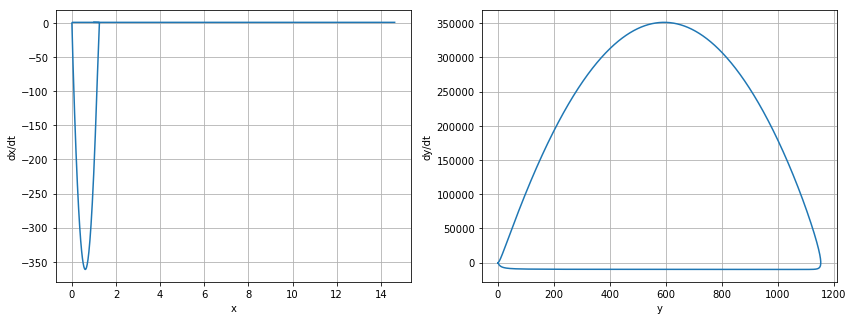

In [33]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1); plt.plot(Y[:,0], Y_[:, 0], '-')
plt.xlabel('x')
plt.ylabel('dx/dt')
plt.grid(); 
plt.subplot(1,2,2); plt.plot(Y[:,1], Y_[:, 1], '-')
plt.xlabel('y')
plt.ylabel('dy/dt')
plt.grid(); plt.show()

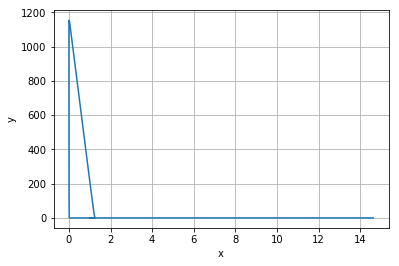

In [11]:
plt.figure() 
plt.subplot(111); plt.plot(Y[:,0], Y[:, 1], '-')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(); plt.show()

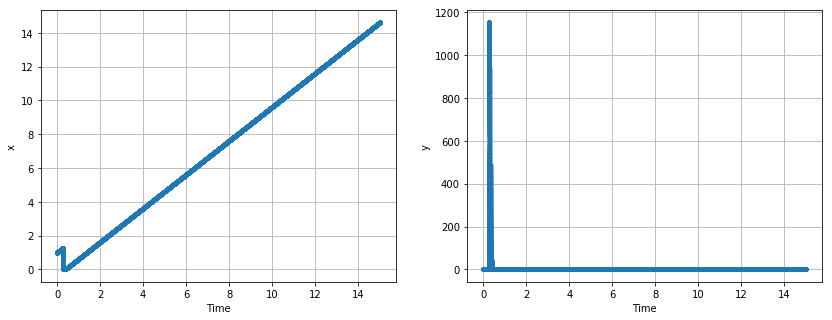

In [12]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1); plt.plot(T, Y[:, 0], '.-')
plt.xlabel('Time')
plt.ylabel('x')
plt.grid()
plt.subplot(1,2,2); plt.plot(T, Y[:, 1], '.-')
plt.xlabel('Time')
plt.ylabel('y')
plt.grid(); plt.show()

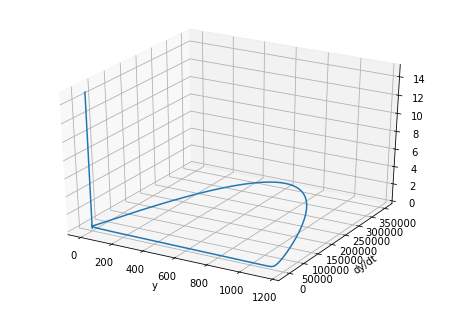

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

x = Y[:,1]
y = Y_[:,1]
z = T

ax.plot(x, y, z, zdir='z', label='zs=0, zdir=z')
plt.xlabel('y')
plt.ylabel('dy/dt')
plt.show()

In [7]:
def newton(F, dFdx, x0):
    x = x0.copy()
    for it in range(50):
        dx = np.linalg.solve(dFdx(x), F(x))
        x -= dx
        if np.linalg.norm(dx) < 1e-12:
            return x
    #print ('max iter num broken')
    return x




$$Kr$$
\begin{array}
{c|cc}
5/8& 5/8& 0\\
1/4 & -1/2& 3/4 \\
\hline
& 2/3 & 1/3
\end{array}


$$Euler$$
\begin{array}
{c|c}
1& 1 \\
\hline
& 1/2
\end{array}

In [8]:
def imeuler(f, h, t, u):
    E = np.eye(len(u))
    k1 = newton(
        lambda k: k - f(t+h, u+h*k), # Уравнение k-f(t+h,u+h*k) = 0
        lambda k: E - h*f(t+h, u+h*k, jac=True), # Производная по k
        f(t, u)) # Начальное приближение
    return u + h*k1/2.
imeuler.order=1; imeuler.name='Неявный Эйлер'

def imkr(f, h, t, u):
    E = np.eye(len(u))
    
    k1 = newton(
        lambda k: k - f(t + 5./8. *h, u + 5./8. * h * k), # Уравнение k-f(t,u) = 0
        lambda k: E - 5./8.*h*f(t + 5./8. *h, u + 5./8. * h * k, jac=True), # Производная по k
        f(t, u)) # Начальное приближение
    
    k2 = newton(
        lambda k: k - f(t+h/4., u-h/2.*k1+3.*h/4.*k), # Уравнение k-f(t+h/2,u+h/2*k) = 0
        lambda k: E - (3.*h/4.)*f(t+h, u-h/2.*k1+3.*h/4.*k, jac=True), # Производная по k
        f(t, u)) # Начальное приближение
    
    return u + h*((2./3.)*k1 + k2/3.)
imkr.order=2; imkr.name='Метод с контрольной'

# Неявный эйлер

In [17]:
%time
T, Y, Y_ = adaptive_stepsize(glicole, glicole_init, glicole_tmax, imeuler, 1e-3, 1e-4)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 24.1 µs
it =  250
|u1 - u2|: 
2.39500066215e-09
err =  4.7900013243e-09
fac =  456.911599223
taunew =  0.000984973267581
curr t =  0.231453691149
it =  500
|u1 - u2|: 
0.000338823405321
err =  0.000677646810641
fac =  1.21478186721
taunew =  0.000472822673401
curr t =  0.471498583849
it =  750
|u1 - u2|: 
0.000323704519975
err =  0.000647409039951
fac =  1.2428268305
taunew =  2.19439765596e-05
curr t =  0.497186331809
it =  1000
|u1 - u2|: 
0.000321572755023
err =  0.000643145510045
fac =  1.24693948972
taunew =  8.60941626177e-06
curr t =  0.500527882817
it =  1250
|u1 - u2|: 
0.000320880156378
err =  0.000641760312757
fac =  1.24828448265
taunew =  5.44539689287e-06
curr t =  0.502218635564
it =  1500
|u1 - u2|: 
0.000320536726052
err =  0.000641073452105
fac =  1.24895302379
taunew =  4.15479170875e-06
curr t =  0.503398951315
it =  1750
|u1 - u2|: 
0.000320294698385
err =  0.00064058939677
fac =  1.24942481447
taunew =  3.538

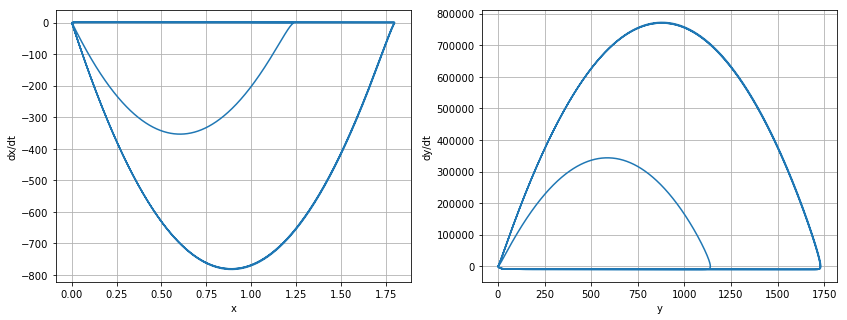

In [18]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1); plt.plot(Y[:,0], Y_[:, 0], '-')
plt.xlabel('x')
plt.ylabel('dx/dt')
plt.grid(); 
plt.subplot(1,2,2); plt.plot(Y[:,1], Y_[:, 1], '-')
plt.xlabel('y')
plt.ylabel('dy/dt')
plt.grid(); plt.show()

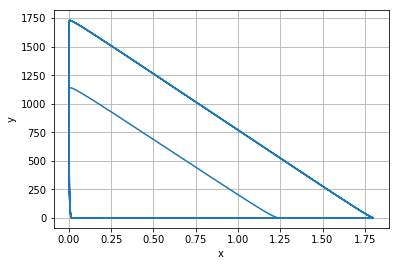

In [19]:
plt.figure() 
plt.subplot(111); plt.plot(Y[:,0], Y[:, 1], '-')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(); plt.show()

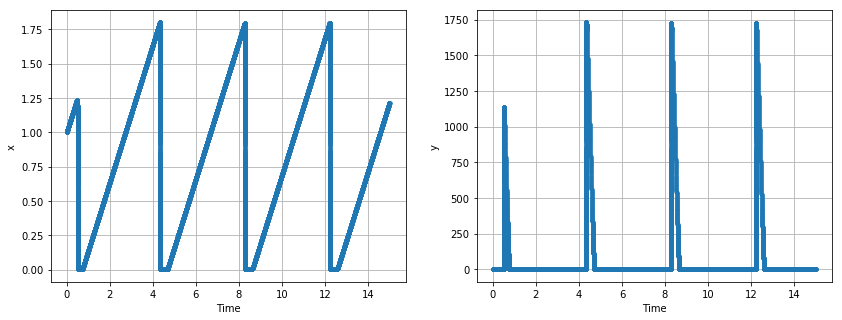

In [20]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1); plt.plot(T, Y[:, 0], '.-')
plt.xlabel('Time')
plt.ylabel('x')
plt.grid()
plt.subplot(1,2,2); plt.plot(T, Y[:, 1], '.-')
plt.xlabel('Time')
plt.ylabel('y')
plt.grid(); plt.show()

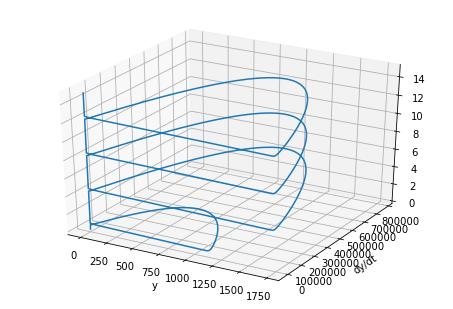

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

x = Y[:,1]
y = Y_[:,1]
z = T

ax.plot(x, y, z, zdir='z', label='zs=0, zdir=z')
plt.xlabel('y')
plt.ylabel('dy/dt')
plt.show()

# Явная средняя точка

In [22]:
T, Y, Y_ = adaptive_stepsize(glicole, glicole_init, glicole_tmax, midpoint, 1e-3, 1e-4)

it =  250
|u1 - u2|: 
1.15633650175e-05
err =  1.54178200233e-05
fac =  4.01783726759
taunew =  0.000984973267581
curr t =  0.231453691149
it =  500
|u1 - u2|: 
0.000368492100779
err =  0.000491322801038
fac =  1.26729491897
taunew =  4.23855880257e-05
curr t =  0.264889712846
it =  750
|u1 - u2|: 
4.69585331454e-10
err =  6.26113775271e-10
fac =  116.891315716
taunew =  0.000991669182524
curr t =  0.412725473319
it =  1000
|u1 - u2|: 
1.67163336477e-84
err =  2.22884448636e-84
fac =  7.65549735648e+26
taunew =  0.000991669182524
curr t =  0.66064276895
it =  1250
|u1 - u2|: 
2.34488031916e-149
err =  3.12650709222e-149
fac =  3.17429189788e+48
taunew =  0.000991669182524
curr t =  0.908560064581
it =  1500
|u1 - u2|: 
0.0
err =  0.0
fac =  6.96182301433e+52
taunew =  0.000991669182524
curr t =  1.15647736021
it =  1750
|u1 - u2|: 
2.22044604925e-16
err =  2.96059473233e-16
fac =  15003.99852
taunew =  0.000991669182524
curr t =  1.40439465584
it =  2000
|u1 - u2|: 
2.22044604925e-16
e

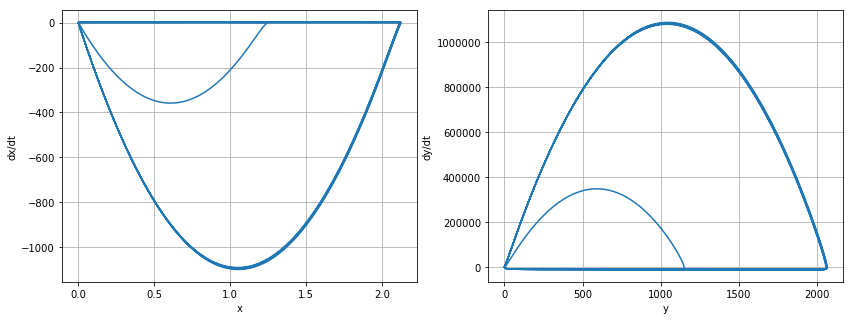

In [23]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1); plt.plot(Y[:,0], Y_[:, 0], '-')
plt.xlabel('x')
plt.ylabel('dx/dt')
plt.grid(); 
plt.subplot(1,2,2); plt.plot(Y[:,1], Y_[:, 1], '-')
plt.xlabel('y')
plt.ylabel('dy/dt')
plt.grid(); plt.show()

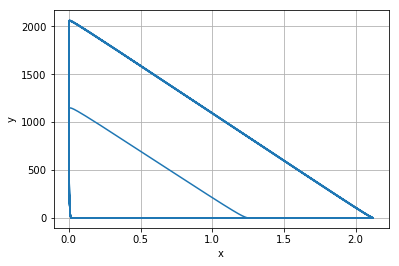

In [24]:
plt.figure() 
plt.subplot(111); plt.plot(Y[:,0], Y[:, 1], '-')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(); plt.show()

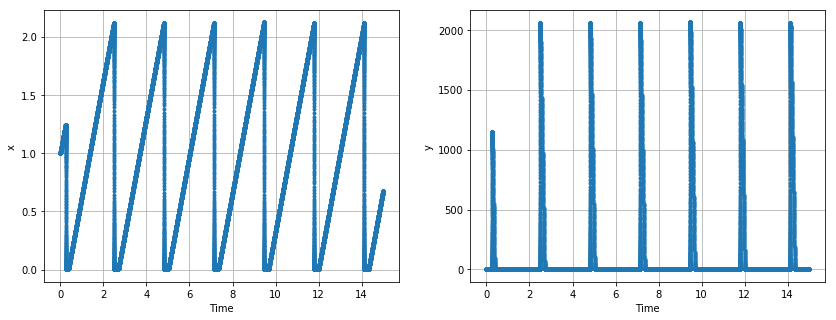

In [25]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1); plt.plot(T, Y[:, 0], '.-')
plt.xlabel('Time')
plt.ylabel('x')
plt.grid()
plt.subplot(1,2,2); plt.plot(T, Y[:, 1], '.-')
plt.xlabel('Time')
plt.ylabel('y')
plt.grid(); plt.show()

In [26]:
a = 1e6 #1e6, 1e3
c = 0.7
b = 6.
def bongoff_van_der_pole(t, u, jac=False):
    y1, y2 = u
    if jac:
        return np.array([[-a * y1**2 + a, a], [-1., -b]])
    return np.array([a * (-(y1**3 / 3. - y1) + y2),
                    -y1 - b * y2 + c])
bongoff_van_der_pole_init = np.array([2, 0])
bongoff_van_der_pole_tmax = 5.

# Неявный метод метод с контрольой

In [9]:
T, Y, Y_ = adaptive_stepsize(glicole, glicole_init, glicole_tmax, imkr, 1e-4, 1e-5, 1e-3)


it =  250
|u1 - u2|: 
6.90956793062e-08
err =  9.21275724083e-08
fac =  10.2770891564
taunew =  0.000970172337849
curr t =  0.205576535624
it =  500
|u1 - u2|: 
3.8127947079e-05
err =  5.08372627719e-05
fac =  1.25296598294
taunew =  1.86875126802e-05
curr t =  0.26088118037
it =  750
|u1 - u2|: 
3.48870300301e-05
err =  4.65160400401e-05
fac =  1.29062207212
taunew =  8.68720790281e-05
curr t =  0.267613988203
it =  1000
|u1 - u2|: 
1.65577875212e-09
err =  2.20770500283e-09
fac =  35.6467263952
taunew =  0.000950651540287
curr t =  0.402874213271
it =  1250
|u1 - u2|: 
5.55111512313e-17
err =  7.40148683083e-17
fac =  11055.0406306
taunew =  0.000950651540287
curr t =  0.640537098343
it =  1500
|u1 - u2|: 
1.11022302463e-16
err =  1.48029736617e-16
fac =  8774.39156332
taunew =  0.000950651540287
curr t =  0.878199983414
it =  1750
|u1 - u2|: 
1.11022302463e-16
err =  1.48029736617e-16
fac =  8774.39156332
taunew =  0.000950651540287
curr t =  1.11586286849
it =  2000
|u1 - u2|: 
1.1

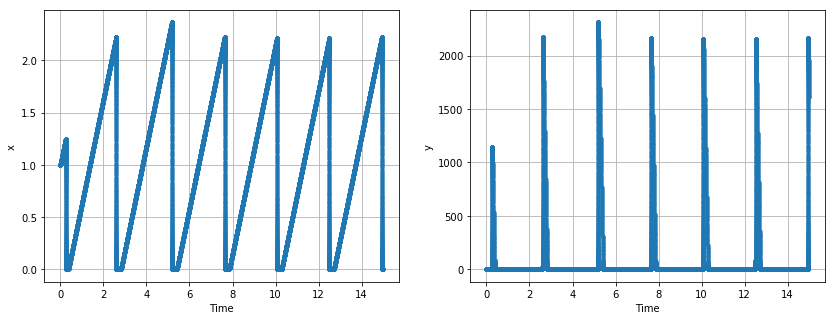

In [10]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1); plt.plot(T, Y[:, 0], '.-')
plt.xlabel('Time')
plt.ylabel('x')
plt.grid()
plt.subplot(1,2,2); plt.plot(T, Y[:, 1], '.-')
plt.xlabel('Time')
plt.ylabel('y')
plt.grid(); plt.show()

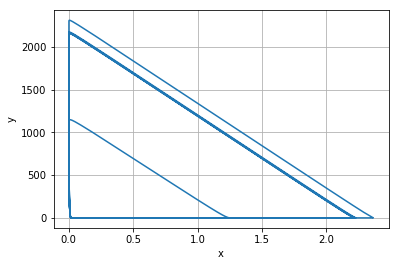

In [11]:
plt.figure() 
plt.subplot(111); plt.plot(Y[:,0], Y[:, 1], '-')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(); plt.show()

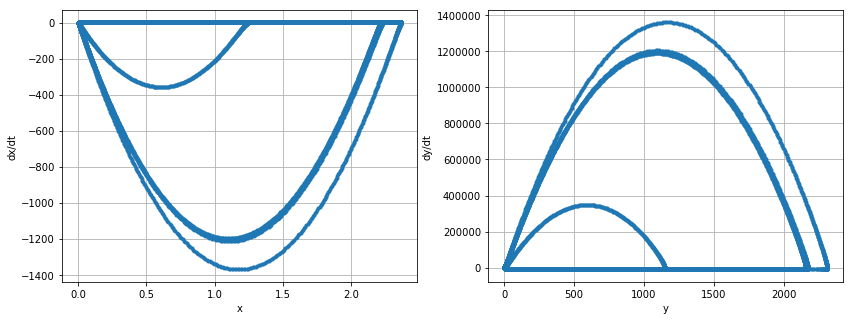

In [12]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1); plt.plot(Y[:,0], Y_[:, 0], '.-')
plt.xlabel('x')
plt.ylabel('dx/dt')
plt.grid(); 
plt.subplot(1,2,2); plt.plot(Y[:,1], Y_[:, 1], '.-')
plt.xlabel('y')
plt.ylabel('dy/dt')
plt.grid(); plt.show()

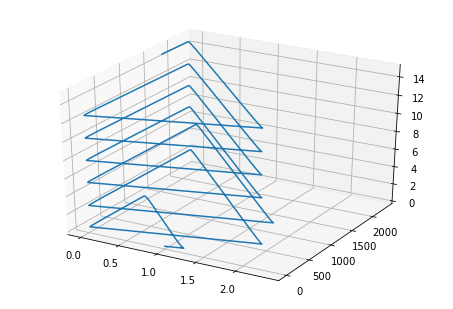

In [31]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

x = Y[:,0]
y = Y[:,1]
z = T

ax.plot(x, y, z, zdir='z', label='zs=0, zdir=z')

plt.show()